In [ ]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random as r
import time as t
import math as m
from IPython.display import clear_output

#Laboratorio 3
##Sebastián Cobaise, Arturo Lazcano, Matías Vera

#Problema 1

Primero se analiza el tamaño de E. La grilla $\Lambda_N$ tiene $(2N+1)^2$ espacios para las moléculas y los espacios que no están en la frontera son $(2*(N-1)+1)^2=(2N-1)^2$, cada una de las moléculas en estos espacios pueden tener un spin de 1 o -1, concluyendo así que:

$|E|=2^{(2N-1)^2}$

En la práctica no es factible calcular $Z(\beta)$ explícitamente pues esto resulta muy costoso, dado que se tienen $2^{(2N-1)^2}$ posibles estados y calcular la energía de un estado $x$ fijo no es trivial, dado que se debe calcular $[x(m)-x(m')]$ para cada par de vecinos $(m,m')$, lo cual no es factible repetir $2^{(2N-1)^2}$ veces.

Para N=10 se tiene que $|E|=2^{19^2}=2^{361}$, por lo que incluso para N pequeños, $|E|$ es una cantidad gigantesca.




Ahora, para implementar un algoritmo tipo Markov Chain Monte Carlo se debe elegir una matriz estocástica R asociada al grafo propuesto en el problema.

Para un estado fijo, se puede cambiar el spin de una molécula y se obtiene un estado vecino en el grafo, como hay $(2N-1)^2$ moléculas donde se puede hacer esto, cada estado tendrá $(2N-1)^2$ vecinos.

**Metropolis:**

$R_{xy}=\frac{1}{(2N-1)^2}$ para $x$~$y$

$\frac{\pi_yR_{yx}}{\pi_xR_{xy}}=\frac{\pi_y}{\pi_x}=e^{-\beta (H(y)-H(x))}$

Como x e y difieren exactamente en el spin de una molécula $m$, para calcular $(H(y)-H(x))$ se debe considerar la molécula $m$ y sus 4 vecinos. 

**Gibbs:**

$R_{xy}=\frac{\pi_y}{\sum_{x\text{~}z}\pi_z}=\frac{e^{-\beta H(y)}}{\sum_{x\text{~}z}e^{-\beta H(z)}}$ para $x$~$y$

$\frac{\pi_yR_{yx}}{\pi_xR_{xy}}=\frac{\pi_y*\pi_x}{\sum_{y\text{~}z}\pi_z}*\frac{\sum_{x\text{~}z}\pi_z}{\pi_y*\pi_x}=\frac{\sum_{x\text{~}z}\pi_z}{\sum_{y\text{~}z}\pi_z}=\frac{\sum_{x\text{~}z}e^{-\beta H(z)}}{\sum_{y\text{~}z}e^{-\beta H(z)}}$

Aquí se debe calcular la energia asociadas a los estados vecinos de x e y.

Se concluye que el algoritmo que conviene usar es el Metropolis, dado que su expresión explícita de $\frac{\pi_yR_{yx}}{\pi_xR_{xy}}$ resulta más simple y menos costosa de calcular.

El algoritmo MCMC para obtener una simulación de $\pi$ en pseudo código es:

Sean $\{U_n\}_{n\geq1}$ i.i.d  $U([0,1])$

1.   Generar $X_0$ según una distribución inicial. $n\leftarrow 0$.
2.   Dado $X_n=x$, simular $Y_{n+1}=y$ eligiendo uniformemente una molécula
     en el interior de la grilla y cambiarle el spin.
3.   Si $U_{n+1}\leq e^{-\beta (H(y)-H(x))}$: $X_{n+1}=Y_{n+1}$

     Si $U_{n+1}>e^{-\beta (H(y)-H(x))}$: $X_{n+1}=X_n$

    $n\leftarrow n+1$
4.   Repetir pasos 2 y 3, la mayor cantidad posibles de veces.

In [ ]:
def Ising(N,beta,nf,p=3/4,intervalo=100):
  #Paso 1
  xn=[]
  for fila in range(2*N+1):
    xn.append([2*np.random.binomial(1,p)-1 for columna in range(2*N+1)])
  #colocar la frontera con spin 1
  for i in range(2*N+1):
    xn[0][i]=1
    xn[i][2*N]=1
    xn[i][0]=1
    xn[2*N][i]=1
  for i in range(nf):
    #Paso 2
    #Simular Yn+1=y (generar el indice de la molecula que cambia)
    fila=r.randint(1,2*N-1)
    col=r.randint(1,2*N-1)

    #Calcular H(y)-H(x) (basta enfocarse en la molecula elegida (m) y sus vecinos)
    m=xn[fila][col]
    vecino1=xn[fila-1][col]
    vecino2=xn[fila+1][col]
    vecino3=xn[fila][col-1]
    vecino4=xn[fila][col+1]
    hyhx=0
    for vec in [vecino1,vecino2,vecino3,vecino4]:
      hyhx+=(-m-vec)**2-(m-vec)**2
    #determinar si cambiar Xn
    u=r.random()
    if u<=np.e**(-beta*hyhx):
      xn[fila][col]=-xn[fila][col]
    if (i+1)%intervalo==0 or i==0:
      fig = plt.figure()
      ax = fig.add_subplot(111)
      cax = ax.matshow(xn, interpolation='nearest',cmap='magma',  vmin=-1, vmax=1)
      fig.colorbar(cax)
      plt.title("Iteracion número " +str(i+1))
      plt.show()
  return xn

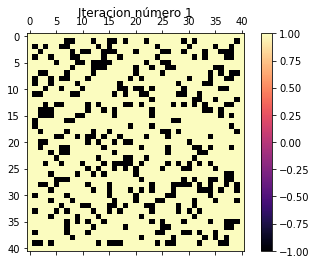

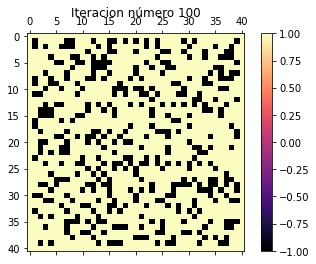

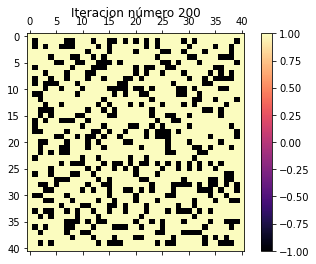

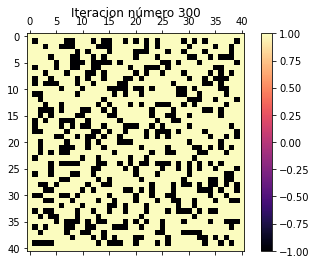

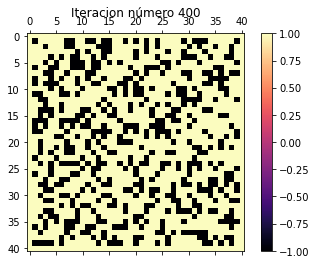

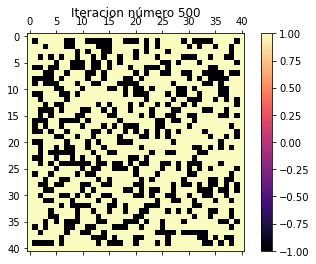

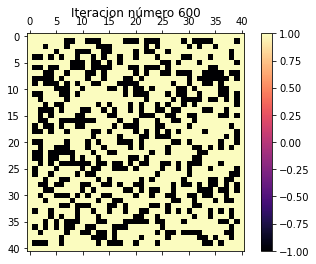

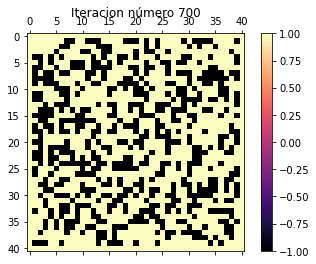

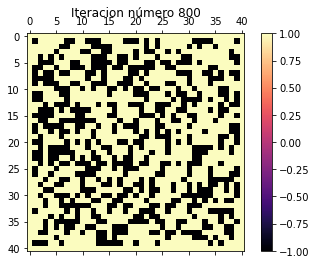

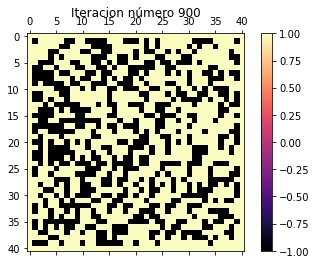

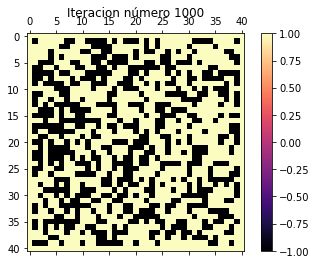

In [ ]:
cadena=Ising(20,0.005,1000)

In [ ]:
#La misma función que Ising, pero los gráficos se presentan como una mini animacion
#demora es la cantidad de segundos de pausa entre iteraciones
#intervalo es cada cuantas iteraciones se muestra la grilla
def AnimacionIsing(N,beta,nf,p=3/4,demora=0.2,intervalo=100):
  #Paso 1
  xn=[]
  for fila in range(2*N+1):
    xn.append([2*np.random.binomial(1,p)-1 for columna in range(2*N+1)])
  #colocar la frontera con spin 1
  for i in range(2*N+1):
    xn[0][i]=1
    xn[i][2*N]=1
    xn[i][0]=1
    xn[2*N][i]=1

  for i in range(nf):
    #Paso 2
    #Simular Yn+1=y (generar el indice de la molecula que cambia)
    fila=r.randint(1,2*N-1)
    col=r.randint(1,2*N-1)

    #Calcular H(y)-H(x) (basta enfocarse en la molecula elegida (m) y sus vecinos)
    m=xn[fila][col]
    vecino1=xn[fila-1][col]
    vecino2=xn[fila+1][col]
    vecino3=xn[fila][col-1]
    vecino4=xn[fila][col+1]
    hyhx=0
    for vec in [vecino1,vecino2,vecino3,vecino4]:
      hyhx+=(-m-vec)**2-(m-vec)**2
    #determinar si cambiar Xn
    u=r.random()
    if u<=np.e**(-beta*hyhx):
      xn[fila][col]=-xn[fila][col]
    if (i+1)%intervalo==0 or i==0:
      fig = plt.figure()
      ax = fig.add_subplot(111)
      cax = ax.matshow(xn, interpolation='nearest',cmap='magma',  vmin=-1, vmax=1)
      fig.colorbar(cax)
      plt.title("Iteracion número " +str(i+1))
      plt.show()
      t.sleep(demora)
      clear_output(wait=True)
  return xn

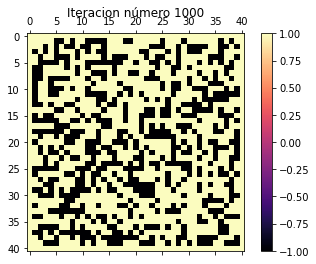

In [ ]:
cadena=AnimacionIsing(20,0.005,1000)

Para estudiar el comportamiento de la cadena en el inicio y al final, resulta más cómodo usar la función Ising, a continuación se prueba para $p=0.55$ y $p=0.99$

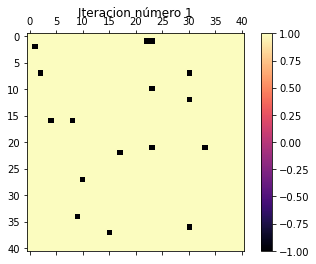

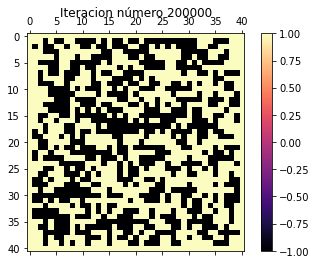

In [ ]:
#p=0.99
cadena=Ising(20,0.05,200000,0.99,200000)

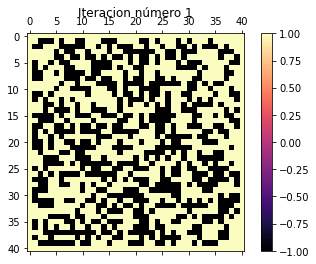

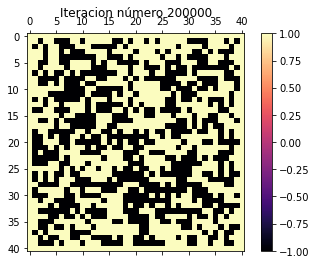

In [ ]:
#p=0.55
cadena=Ising(20,0.05,200000,0.55,200000)

Al observar el principio de ambas cadenas, la diferencia del $p$ es relevante, para $p=0.55$ la cantidad de moléculas con spin=$-1$ es mucho mayor que la cadena con $p=0.99$.

Sin embargo, en la iteración final no se observan diferencias sustanciales entre ambos valores de $p$, esto tiene mucho sentido, pues $p$ solo marca diferencia en la condición inicial que no incide en el comportamiento de la cadena en el largo plazo, por lo que no importa mucho.

Se fija $p=3/4$.

Ahora, se estudia la influencia de $\beta$ en el resultado.

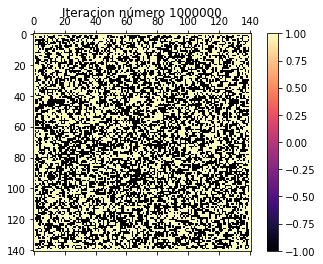

In [ ]:
#beta=0.05
beta=0.05
p=0.75
N=70
nf=1000000
cadena=AnimacionIsing(N,beta,nf,p=3/4,demora=0.005,intervalo=100000)

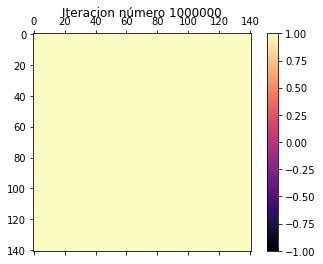

In [ ]:
#beta=6
beta=6
p=0.75
N=70
nf=1000000
cadena=AnimacionIsing(N,beta,nf,p=3/4,demora=0.005,intervalo=100000)

Lo Principal a observar es que para $\beta=6$ llega un momento donde todos los spins se vuelven 1, mientras que para $\beta=0.05$ hay una "coexistencia" entre ambos spins, sin que uno predomine.

Este resultado es congruente con el planteamiento del algoritmo, dado que en el paso 3 se compara una variable aleatoria uniforme $U_{n+1}$ con el valor de $e^{-\beta (H(y)-H(x))}$.

Si $\beta>0$ es muy pequeño, será más probable el caso donde $U_{n+1}\leq e^{-\beta (H(y)-H(x))}$, por lo que cualquier cambio en la cadena es considerablemente probable, en cambio, si $\beta>0$ es suficientemente grande, $U_{n+1}\leq e^{-\beta (H(y)-H(x))}$ será mucho más probable cuando $(H(y)-H(x))\leq0$, es decir, las transiciones más probables del estado $x$ al $y$ son las que reducen o mantienen la energía $H$. 

Para seguir estudiando la transición de fase, se corre la cadena para varios valores de $\beta$ durante un tiempo grande y se estudia desde qué $\beta_C$ el spin promedio es muy cercano a 1.

Se fija $nf=1,000,000$.

In [ ]:
#El Algoritmo sin que imprima los estados
def IsingSimple(N,beta,nf,p=3/4):
  #Paso 1
  xn=[]
  for fila in range(2*N+1):
    xn.append([2*np.random.binomial(1,p)-1 for columna in range(2*N+1)])
  #colocar la frontera con spin 1
  for i in range(2*N+1):
    xn[0][i]=1
    xn[i][2*N]=1
    xn[i][0]=1
    xn[2*N][i]=1

  for i in range(nf):
    #Paso 2
    #Simular Yn+1=y (generar el indice de la molecula que cambia)
    fila=r.randint(1,2*N-1)
    col=r.randint(1,2*N-1)

    #Calcular H(y)-H(x) (basta enfocarse en la molecula elegida (m) y sus vecinos)
    m=xn[fila][col]
    vecino1=xn[fila-1][col]
    vecino2=xn[fila+1][col]
    vecino3=xn[fila][col-1]
    vecino4=xn[fila][col+1]
    hyhx=0
    for vec in [vecino1,vecino2,vecino3,vecino4]:
      hyhx+=(-m-vec)**2-(m-vec)**2
    #determinar si cambiar Xn
    u=r.random()
    if u<=np.e**(-beta*hyhx):
      xn[fila][col]=-xn[fila][col]
  return xn

([<matplotlib.axis.XTick at 0x7f09bf6f2390>,
 <a list of 20 Text major ticklabel objects>)

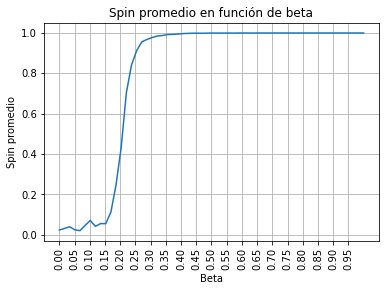

In [ ]:
#OJO: Este código demora ~7 minutos
nf=1000000
N=70
p=3/4
betas=np.linspace(0,1,60)
ss=[]
for beta in betas:
  xnf=IsingSimple(N,beta,nf,p=3/4)
  s=np.mean(xnf)
  ss.append(s)

plt.plot(betas,ss)
plt.title("Spin promedio en función de beta")
plt.xlabel("Beta")
plt.ylabel("Spin promedio")
plt.grid()
plt.xticks(np.arange(0, 1, step=0.05),rotation='vertical')

A partir del gráfico una primera estimación de $\beta_C$ es 0.4, cercano a este valor en adelante el spin promedio de la simulación está muy cerca a 1.

Ahora se repite el mismo experimento en un intervalo centrado a la primera estimación realizada para $\beta_C$.

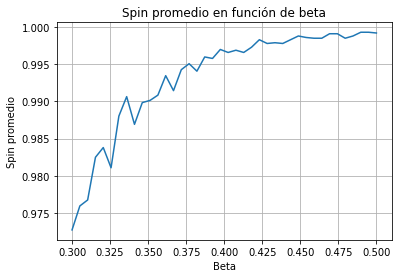

In [ ]:
#OJO: Este código demora ~13 minutos
nf=3000000
N=70
p=3/4
betas=np.linspace(0.3,0.5,40)
ss=[]
for beta in betas:
  xnf=IsingSimple(N,beta,nf,p=3/4)
  s=np.mean(xnf)
  ss.append(s)

plt.plot(betas,ss)
plt.title("Spin promedio en función de beta")
plt.xlabel("Beta")
plt.ylabel("Spin promedio")
plt.grid()

Se estima que el valor de $\beta_C$ es 0.45, pues desde este valor en adelante se observa un comportamiento parecido, casi siempre por sobre $0.999$ de spin promedio.

Según [1], el valor crítico $\beta_C$ corresponde aproximadamente a $0.4407$, por lo que se concluye que la estimación resulta bastante buena.


[1] Alan Morningstar and Roger G. Melko. 2017. Deep learning the ising model near criticality. J. Mach. Learn. Res. 18, 1 (January 2017), 5975–5991.



```
# Tiene formato de código
```

# Problema 2

1.- y 2.- \\
En la siguiente celda se resolverán las primeras dos partes de esta pregunta. La primera función genera $N$ ciudades ubicadas dentro del plano $[0,1] \times [0,1]$ generando también una matriz $D$ de distancias, donde $D_{ij}$ representa la distancia euclidea entre la ciudad $i$ y la $j$.
Por otro lado, la segunda función se encarga de graficar el camino recorrido dada una permutación como parámetro con la condición de que $\sigma(1)=1$.

In [ ]:
# Función que genera N ciudades y su matriz de distancias D
def Ciudades(N):
  C=[]
  D=np.zeros((N,N))
  for i in range(N):
    x=r.uniform(0,1)
    y=r.uniform(0,1)
    C.append(np.array((x,y)))
  for i in range(len(C)):
    for j in range(len(C)):
      dist=np.linalg.norm(C[i]-C[j])
      D[i,j]=dist
  return (C,D)

# Función que grafica el camino entre ciudades dada una permutación
def graficoCamino(camino,ciudades):
  plt.figure(figsize=(13,8))
  contador=1
  for c in ciudades:
    plt.scatter(c[0],c[1],label='Ciudad'+str(contador),s=2*100)
    plt.annotate(str(contador),(c[0],c[1]),xytext=(c[0]-0.03, c[1]-0.03))
    contador+=1
  for i in range(len(camino)-1):
    plt.plot([ciudades[camino[i]-1][0],ciudades[camino[i+1]-1][0]],[ciudades[camino[i]-1][1],ciudades[camino[i+1]-1][1]], color='c')
  plt.plot([ciudades[camino[0]-1][0], ciudades[camino[len(camino)-1]-1][0]],[ciudades[camino[0]-1][1], ciudades[camino[len(camino)-1]-1][1]],color='r')
  plt.axis([0, 1.05, 0, 1.05])
  #plt.legend(loc=(1.05,0.6),prop={"size":15})
  plt.xlabel("$[0,1]$", fontsize=18)
  plt.ylabel("$[0,1]$", fontsize=18)
  plt.title(r'Recorrido del vendedor viajero en $[0,1] \times [0,1]$', fontsize=18)

El siguiente gráfico es un test de 5 ciudades y su recorrido dibujado en el plano. Notar que acá la linea roja representa el último camino que se recorre, esto para terminar el ciclo en la primera ciudad y saber cual fue el orden realizado.

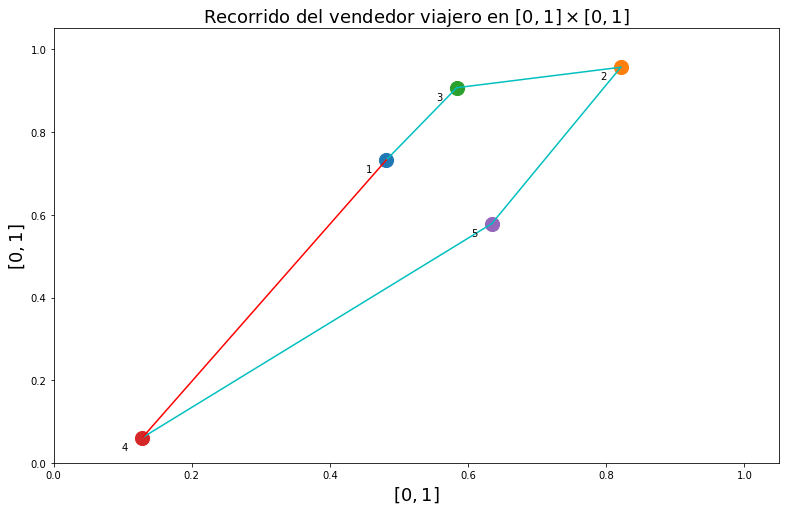

In [ ]:
# Test de las funciones anteriormente descritas con 5 ciudades y una permutación [1,3,2,5,4]
# La leyenda solo se mostrará cuando sean pocas ciudades para mayor claridad
cc=Ciudades(5)[0]
permutacion=[1,3,2,5,4]
graficoCamino(permutacion,cc)

3- Se define $osc_K(w)=\max \{ w(\tau)- w(\sigma) ~ ; ~ \sigma \sim \tau \} $. Dar una cota superior para $osc_K(w)$ para cada $N$, que no dependa de la posición de las ciudades.

Sean $\sigma, \tau \in E$ tales que $\sigma \sim \tau$, entonces se tiene que, si su permutación fue $k$ por $j$, entonces, se tiene que $\forall n \not = k,j, ~\sigma(n)=\tau(n)$. Utilizando esto se llega a que:

$$w(\tau)-w(\sigma)=\sum_{i=1}^N d(\tau(i), \tau(i+1)) -\sum_{i=1}^N d(\sigma(i), \sigma(i+1)) = \\ d(\tau(k-1), \tau(k))+d(\tau(k), \tau(k+1))+d(\tau(j-1), \tau(j))+d(\tau(j), \tau(j+1)) - \\
[d(\sigma(k-1), \sigma(k))+d(\sigma(k), \sigma(k+1))+d(\sigma(j-1), \sigma(j))+d(\sigma(j), \sigma(j+1))] \leq \\
d(\tau(k-1), \tau(k))+d(\tau(k), \tau(k+1))+d(\tau(j-1), \tau(j))+d(\tau(j), \tau(j+1)) $$

Como la mayor distancia que se puede tener entre 2 puntos en el cuadrado unitario es $\sqrt{2}$, entonces:
$$w(\tau)-w(\sigma) \leq \sqrt{2}+\sqrt{2}+\sqrt{2}+\sqrt{2}=4\sqrt{2}$$
Tomando máximo a ambos lados, se tiene que:
$$osc_K(w)\leq 4 \sqrt{2} $$

Obteniendo una cota superior para $osc_K(w)$.

En la siguiente parte de esta pregunta, se definirán varias funciones auxiliares con el fin de hacer más fácil la implementación de la cadena.
Estas funciones calculan la distancia recorrida (distrec), generan distintos tipos de $\beta$ según el crecimiento que se quiera, se generan permutaciones al azar entre ciudades (permutacion) y se termina haciendo el código final simulando una cadena (CadenaRS).

In [ ]:
def distrec(C,Perm):
  A=0
  for i in range(len(Perm)-1):
    A+=np.linalg.norm(C[Perm[i]]-C[Perm[i+1]])
  A+=np.linalg.norm(C[Perm[len(Perm)-1]] + C[Perm[0]])
  return A

print(distrec(cc, [0,3,4,1,2]))

#Como 4*sqrt(2) es parecido a 5,65, consideramos C=(N-1)*6
def betalog(n,N):
  C=(N-1)*6
  e=m.exp(1)
  B=(1/C)*m.log(n+e)
  return B

4.099580552425427


In [ ]:
def permutacion(arreglo):
  X=arreglo.copy()
  L=r.sample(range(1,len(arreglo)),2)
  a=X[L[0]]
  b=X[L[1]]
  X[L[0]]=b
  X[L[1]]=a
  return X

test=[1,4,6,2,5,3]
permutacion(test)

[1, 5, 6, 2, 4, 3]

In [ ]:
#Ya con esto listo, se puede implementar una función usando recocido simulado
#U es una sucesion Unif=np.random.uniform(size=n) 

def CadenaRS(C,n,betas, X0, Unif):
  N=len(C)
  X=np.zeros((n,N), dtype=int)
  #se considera una condición inicial
  X[0]=X0.copy()
  w1=0
  w2=0
  for i in range(1,n):
    camino1=X[i-1].copy()
    w1=distrec(C,camino1)
    Bn=betas(i-1,N)
    camino2 = permutacion(camino1).copy()
    w2=distrec(C,camino2)
    Pifrac=(np.exp(-Bn*(w2-w1)))
    if Unif[i] <= Pifrac :
      X[i]=camino2.copy()
    else:
      X[i]=X[i-1].copy()
  return X

U=np.random.uniform(size=100)
print(CadenaRS(cc,100,betalog,np.array([0,1,2,3,4]),U)[99])

#Ahora implementemos otros crecimientos de beta

def betalineal(n,N):
  C=(N-1)*6
  B=(1/C)*(n+1)
  return B

def betacuadratico(n,N):
  C=(N-1)*6
  B=(1/C)*((n+1)**2)
  return B

def betalogistico(n,N):
  C=(N-1)*6
  e=np.exp(1)
  B=(1/C)*(n+1)*m.log(n+e)
  return B

def betaexponencial(n,N):
  C=(N-1)*6
  B=(1/C)*np.exp(n)
  return B
  

[0 3 1 4 2]


En la siguiente celda se simularán $N=20$ ciudades en el plano y se aproximará un mínimo global de $w$.
Se define una función que toma como parámetro un método que será lineal, cuadrático, exponencial, logarítmico o pseudolineal. Dependiendo de esto último, cambiará la sucesión $\beta_n$ usada para Metropolis-Hastings. 

In [ ]:
CC=Ciudades(20)
ciudades=CC[0]
n1=10**4
n2=10**3
U1=np.random.uniform(size=n1)
U2=np.random.uniform(size=n2)
Xinicial=np.arange(20)

Acá se generarán diferentes cadenas dependiendo de las distintas formas de obtener la sucesión $\beta_n$. En este caso, será de forma lineal, cuadrática, exponencial, logarítmica y pseudolineal.
Todo esto para una cantidad de pasos $n=10000$.

In [ ]:
Cadena1=CadenaRS(ciudades, n1, betalineal, np.arange(20),U1)[n1-1]
Cadena2=CadenaRS(ciudades, n1, betacuadratico, np.arange(20),U1)[n1-1]
Cadena3=CadenaRS(ciudades, n1, betalogistico, np.arange(20),U1)[n1-1]
Cadena4=CadenaRS(ciudades, n1, betaexponencial, np.arange(20),U1)[n1-1]
Cadena5=CadenaRS(ciudades, n1, betalog, np.arange(20),U1)[n1-1]
#print(Cadena)
def ajustar(arreglo):
  for i in range(len(arreglo)):
    arreglo[i]+=1
  return arreglo
#print(ajustar(Cadena))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp


Gráfico con $\beta_n$ creciendo linealmente.

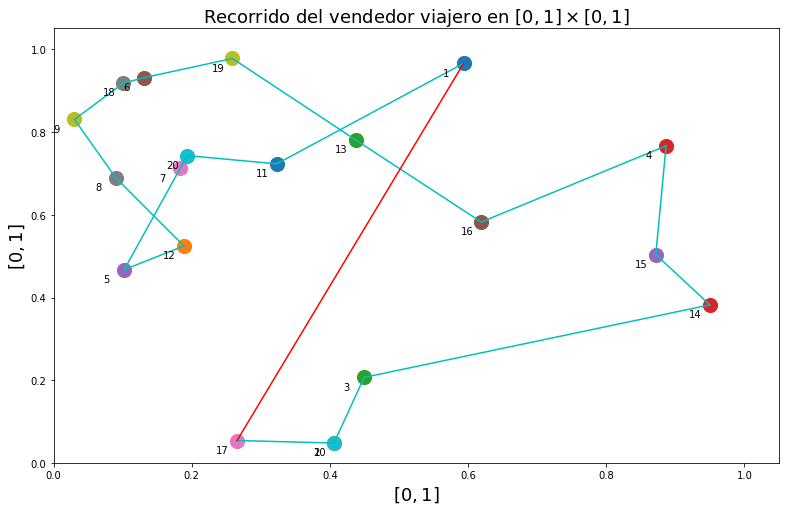

In [ ]:

graficoCamino(ajustar(Cadena1),ciudades)

Gráfico con $\beta_n$ creciendo cuadráticamente.

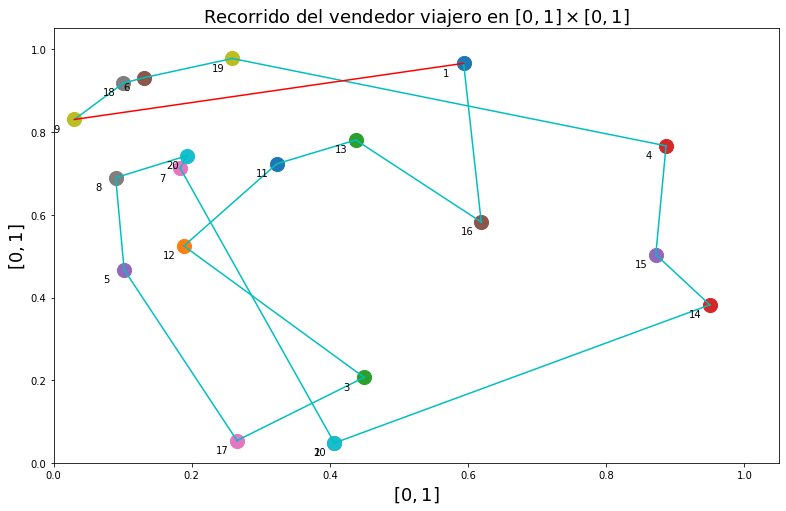

In [ ]:
graficoCamino(ajustar(Cadena2),ciudades)

Gráfico con $\beta_n$ creciendo pseudolinealmente ($nlog(n)$)

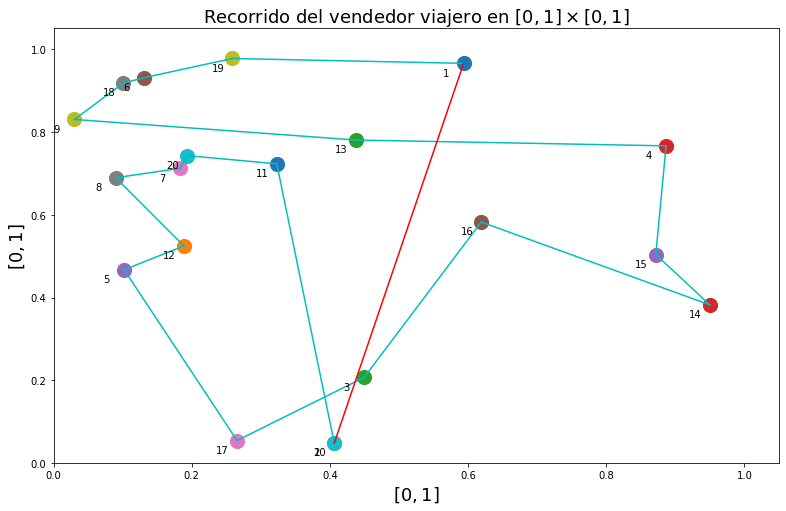

In [ ]:
graficoCamino(ajustar(Cadena3),ciudades)

Gráfico con $\beta_n$ creciendo exponencialmente.

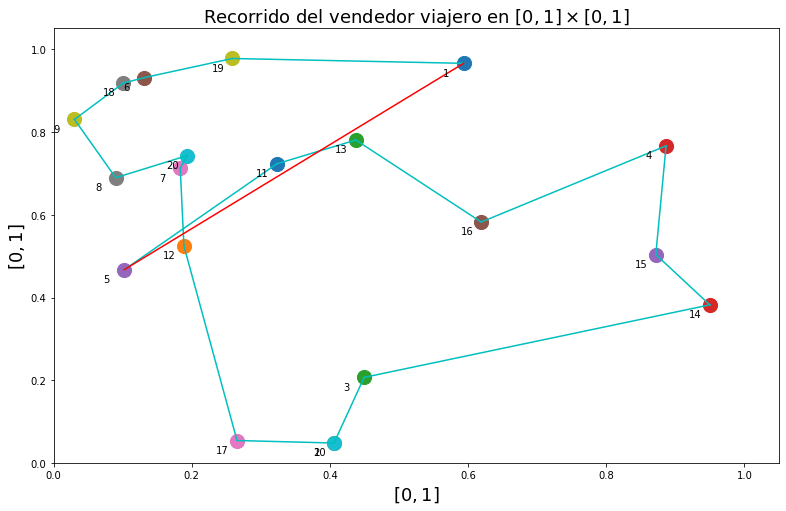

In [ ]:
graficoCamino(ajustar(Cadena4),ciudades)

Gráfico con $\beta_n$ creciendo de forma logarítmica.

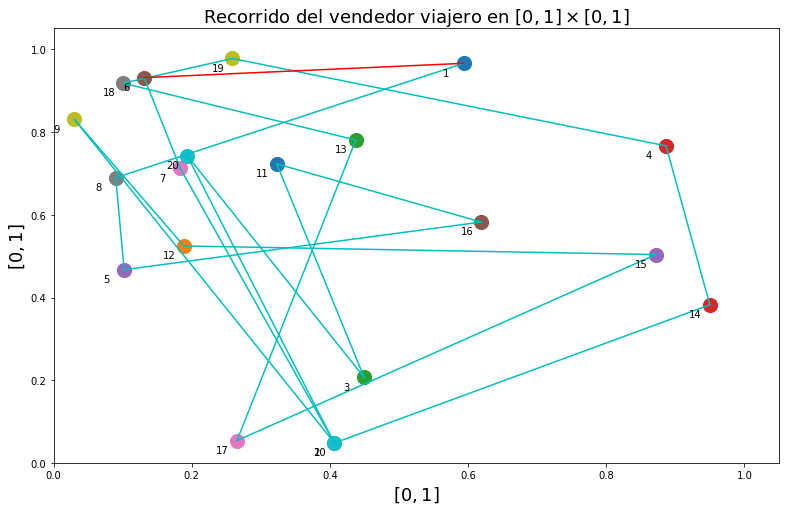

In [ ]:
graficoCamino(ajustar(Cadena5),ciudades)

In [ ]:
def EvolDistancias(C,CadenaMarkov,n):
  A=np.zeros(n)
  for i in range(n):
    A[i]=distrec(C,CadenaMarkov[i])
  return A

CM1=CadenaRS(ciudades, n1, betalineal, np.arange(20),U1)
y1=EvolDistancias(ciudades, CM1,n1)

CM2=CadenaRS(ciudades, n1, betacuadratico, np.arange(20),U1)
y2=EvolDistancias(ciudades, CM2,n1)

CM3=CadenaRS(ciudades, n1, betalogistico, np.arange(20),U1)
y3=EvolDistancias(ciudades, CM3,n1)

CM4=CadenaRS(ciudades, n1, betaexponencial, np.arange(20),U1)
y4=EvolDistancias(ciudades, CM4,n1)

CM5=CadenaRS(ciudades, n1, betalog, np.arange(20),U1)
y5=EvolDistancias(ciudades, CM5,n1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp


En este último gráfico se comparan las 5 formas de modelar esta cadena dependiendo de los valores y del crecimiento de $\beta_n$. Todo esto realizado con un valor de pasos $n=10000$

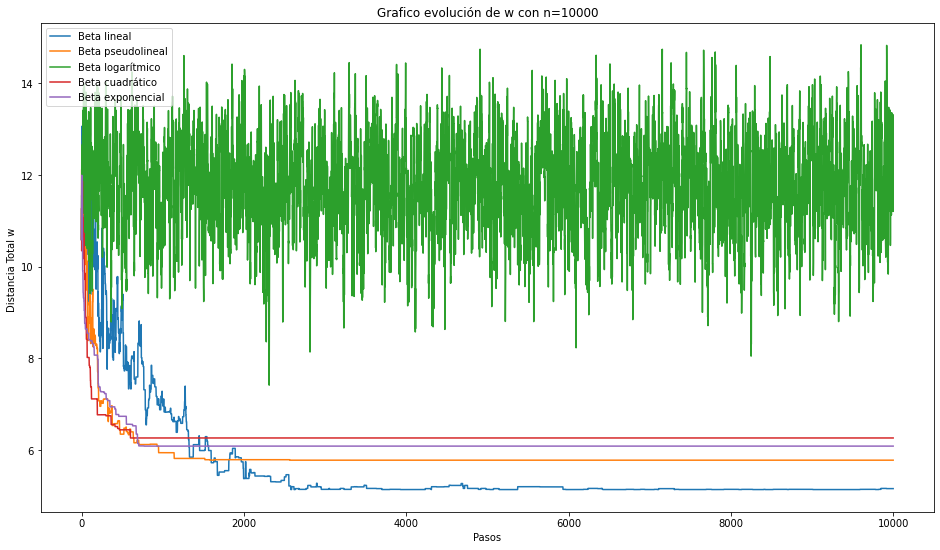

In [ ]:
x = np.arange(0, n1, 1)
fig, ax = plt.subplots(figsize=(16,9))
plt.xlabel('Pasos')
plt.ylabel('Distancia Total w ')
plt.title("Grafico evolución de w con n=10000")
ax.plot(x, y1 , label="Beta lineal")
ax.plot(x, y3 , label="Beta pseudolineal")
ax.plot(x, y5 , label="Beta logarítmico")
ax.plot(x, y2 , label="Beta cuadrático")
ax.plot(x, y4 , label="Beta exponencial")
ax.legend()
plt.show()

## Conclusiones

Como se puede observar en los gráficos anteriores, el crecimiento logarítmico, a pesar de ser teóricamente correcto, es una implementación demasiado lenta en la práctica. Aún más, se observa como si fuera oscilante en todo el rango de $[0,10000]$. \\
Por otro lado, notamos que el crecimiento lineal es el mejor en la práctica superando a los métodos pseudolineal y exponenciales alrededor de $n=2000$. Sin embargo, el modelo exponencial es útil cuando se requiere llegar a mínimos locales de forma rápida. \\
La forma de crecimiento cuadrática no  tan resultó eficaz en la implementación comparada con la linea, quedandose estancada en un valor no óptimo. \\
Por último, estas conclusiones se mantuvieron generando distintas ciudades pero se observaron notorios cambios en el recorrido final.